In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 시각화를 위한 설정
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-1-f8527b531f02>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Batch Normalization 개념

### 1.1 Internal Covariate Shift 문제

-  Internal Covariate Shift는 신경망의 각 층을 통과할 때마다 입력 분포가 변하는 현상을 말합니다.

이는 다음과 같은 문제를 일으킵니다:
- 학습 속도 저하
- 파라미터의 초기값에 민감
- 높은 학습률 사용이 어려움

### 1.2 Batch Normalization의 해결 방법

미니배치 단위로 데이터를 정규화하여 분포를 안정화시킵니다.
1. 평균을 0으로
2. 분산을 1로
3. scale(γ)과 shift(β) 파라미터를 통한 정규화된 값의 변환

## 2. Batch Normalization 구현

In [ ]:
# BatchNorm을 사용하지 않는 모델
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# BatchNorm을 사용하는 모델
class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

## 3. 학습 및 비교 실험

In [ ]:
# MNIST 데이터 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.82MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def train_model(model, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    return train_losses, train_accs

In [ ]:
# 두 모델 학습
model_without_bn = SimpleNet()
model_with_bn = BatchNormNet()

losses_without_bn, accs_without_bn = train_model(model_without_bn)
losses_with_bn, accs_with_bn = train_model(model_with_bn)

Epoch [1/10], Loss: 0.2253, Accuracy: 93.19%
Epoch [2/10], Loss: 0.0920, Accuracy: 97.20%
Epoch [3/10], Loss: 0.0647, Accuracy: 97.90%
Epoch [4/10], Loss: 0.0501, Accuracy: 98.37%
Epoch [5/10], Loss: 0.0396, Accuracy: 98.71%
Epoch [6/10], Loss: 0.0331, Accuracy: 98.90%
Epoch [7/10], Loss: 0.0291, Accuracy: 99.01%
Epoch [8/10], Loss: 0.0234, Accuracy: 99.24%
Epoch [9/10], Loss: 0.0216, Accuracy: 99.28%
Epoch [10/10], Loss: 0.0208, Accuracy: 99.30%
Epoch [1/10], Loss: 0.2054, Accuracy: 94.32%
Epoch [2/10], Loss: 0.0841, Accuracy: 97.43%
Epoch [3/10], Loss: 0.0594, Accuracy: 98.09%
Epoch [4/10], Loss: 0.0462, Accuracy: 98.54%
Epoch [5/10], Loss: 0.0383, Accuracy: 98.72%
Epoch [6/10], Loss: 0.0300, Accuracy: 99.00%
Epoch [7/10], Loss: 0.0260, Accuracy: 99.13%
Epoch [8/10], Loss: 0.0241, Accuracy: 99.23%
Epoch [9/10], Loss: 0.0182, Accuracy: 99.38%
Epoch [10/10], Loss: 0.0165, Accuracy: 99.48%


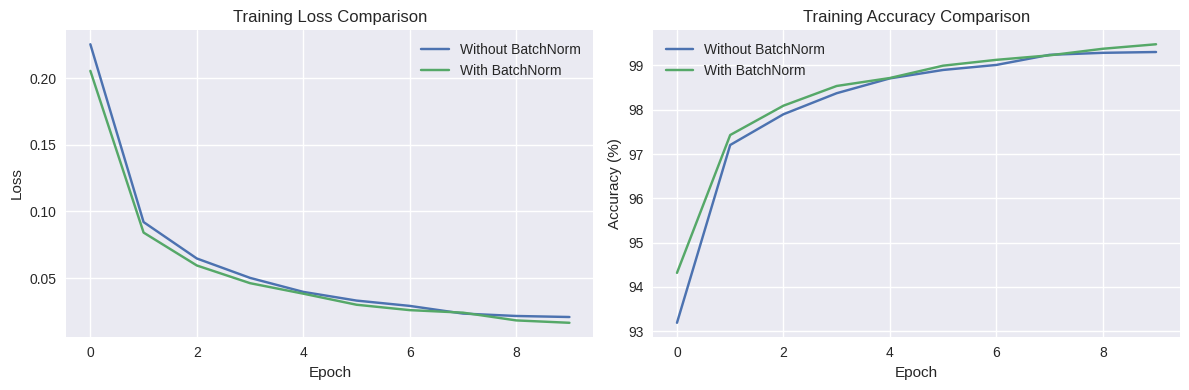

In [ ]:
## 4. 결과 시각화 및 분석

plt.figure(figsize=(12, 4))

# Loss 비교
plt.subplot(1, 2, 1)
plt.plot(losses_without_bn, label='Without BatchNorm')
plt.plot(losses_with_bn, label='With BatchNorm')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 비교
plt.subplot(1, 2, 2)
plt.plot(accs_without_bn, label='Without BatchNorm')
plt.plot(accs_with_bn, label='With BatchNorm')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 5. 코드 해석

BatchNorm을 사용한 모델의 주요 특징

1. nn.BatchNorm1d 레이어가 각 완전연결층 뒤에 추가됨
2. forward 함수에서 배치 정규화가 활성화 함수(ReLU) 이전에 적용됨
3. 배치 정규화 레이어는 학습 가능한 파라미터 γ(scale)와 β(shift)를 포함

## 6. 결과 해석

BatchNorm의 효과

1. 학습 속도 향상
    - Loss가 더 빠르게 감소하는 것을 확인할 수 있음
    - 초기 학습 단계에서 특히 효과적

2. 학습 안정성 향상
    - Loss 곡선이 더 부드럽고 안정적
    - 정확도가 더 일관되게 증가

3. 정규화 효과
    - 과적합 위험 감소
    - 더 나은 일반화 성능

주의사항:
- 배치 크기가 너무 작으면 BatchNorm의 효과가 제한적일 수 있음
- 추론 시에는 학습 중에 계산된 이동 평균과 분산을 사용
- GPU 메모리 사용량이 약간 증가할 수 있음